In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

tqdm.pandas(ascii=True)
%matplotlib inline

#https://networkx.github.io/documentation/networkx-1.7/tutorial/tutorial.html

In [4]:
# read excel file
df = pd.read_excel('../final_relation.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '../final_relation.xlsx'

In [20]:
# sort
df = df.sort_values(['Node_1', 'Node_2'])

In [21]:
df.Node_1 = df.Node_1.progress_apply(lambda x:x.strip())
df.Node_2 = df.Node_2.progress_apply(lambda x:x.strip())

100%|##########| 122/122 [00:00<00:00, 122067.05it/s]


In [22]:
# drop duplicates
df = df.drop_duplicates(['Node_1', 'Node_2'])

In [24]:
df.to_excel('./final_relation.xlsx')

In [25]:
print(len(df))

121


In [26]:
G=nx.Graph()

In [27]:
nodes = set(df['Node_1']) & set(df['Node_2'])
edges = list(zip(df['Node_1'], df['Node_2']))

In [28]:
G.add_nodes_from(nodes)

In [29]:
G.add_edges_from(edges)

In [30]:
degree = pd.DataFrame(list(G.degree), columns = ['nodes', 'degree']).sort_values('degree')

In [54]:
plot = lambda S: nx.draw_circular(S, with_labels = True, 
                                  edge_color = 'gray',
                            
                                  node_color='lightblue',
                                  node_size=2000)

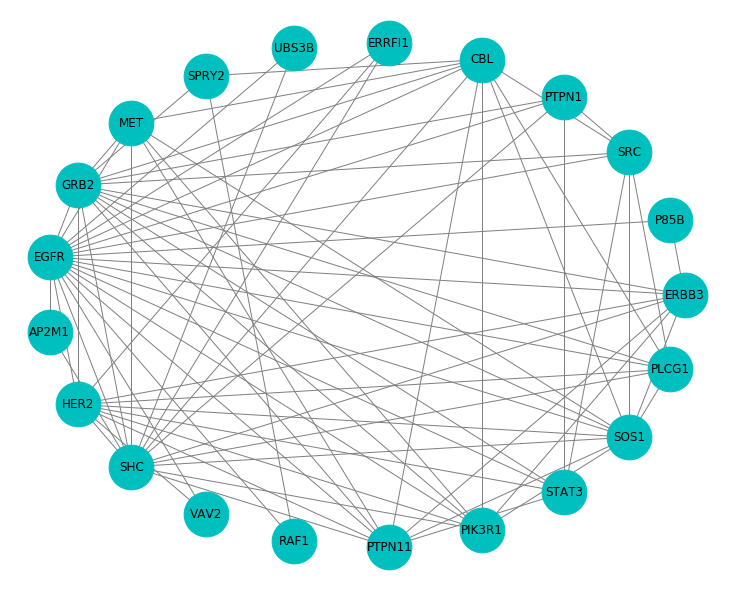

In [56]:
plt.figure(figsize=(10,8))
plot(G)

In [34]:
def g(c = 1):
    G=nx.Graph()
    if c == 0:
        edges = [(0,1), (1,2), (2,3)]
    elif c == 1:
        edges = [(0,1), (1,2), (2,3) , (3,1)]
        
    elif c == 2:
        edges = [(0,1),(0,2), (1,2),(1,3), (2,3)]
    elif c == 3:
        edges =  [(0,1), (1,2), (2,3) , (3,0)]
        
    elif c == 4:
        edges =  [(0,1), (1,2), (2,3) , (3,0), (0,2), (1,3)]
        
    G.add_edges_from(edges)
    return G

def force_score(G):
    S = len(G.edges)
    V = len(G.nodes)
    alpha = S/V
    
    DG = nx.DiGraph(G)
    x = list(nx.simple_cycles(DG))
    y = [i for i in x if len(i) == V]
    
    if len(y) == 0:
        beta = 0
    else:
        beta = len(y) / V
    
    score = round(alpha*0.5 + beta*0.5, 5)
    return score


def get_mer(G, mer = 6):
    nodes = list(G.nodes)
    res_all = []
    for source in nodes:
        for target in nodes:
            if source == target:
                continue
            else:
                res = [set(i) for i in nx.all_simple_paths(G, source, target,  cutoff=mer) if len(i) == mer]
                res_all.extend(res)
                
    df = pd.DataFrame([set(i) for i in res_all])
    
    df = df.drop_duplicates(df.columns)
    df = df.sort_values(df.columns.tolist()).reset_index(drop = True)
    return df
            
    
def get_score(row):
    S = G.subgraph(row.tolist())
    return S

def draw(G, score, fname):
    ax = plt.figure()
    ax = nx.draw_circular(G, with_labels = True, node_color = 'c', edge_color = 'gray', node_size=2000)
    plt.axis('off')
    plt.text(-1,1,'score: %s' % score, fontsize=20)
    plt.savefig(fname, bbox_inches="tight")
    
def _apply_draw(row, dirs):
    G = row.graph
    S = row.score
    fname = str(row.name)
    fname = fname.zfill(5)
    
    name = os.path.join(dirs, str(fname))
    draw(G, S, name)

In [38]:
for mer in [3,4,5,6]:
    name = './mer_%s/' % mer
    dirs = './mer_%s/img/' % mer
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    df3 = get_mer(G, mer)
    df3['graph'] = df3.apply(get_score, axis=1)
    df3['score'] = df3['graph'].apply(force_score)
    df3 = df3.sort_values('score', ascending = False).reset_index(drop = True)
    df3.to_excel(os.path.join(name, '%s.xlsx' % mer))
    _apply = lambda x:_apply_draw(x, dirs)
    df3.progress_apply(_apply, dirs, axis=1)

In [ ]:
! zip -r mer.zip ./mer_*

In [ ]:
ls -lh